In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.rcParams.update({'font.size':12})
plt.rcParams.update({'legend.fontsize': 11})
plt.rcParams.update({'text.usetex':'True'})

scripts for calculate dihedral

In [ ]:
base = r'PVDF_June15_2021/opt/test/'
natoms = 72 
df = pd.read_csv(base+'xmolout',skiprows=2,nrows=natoms,header=None,sep='\s+',usecols=[0,1,2,3,4])
df.columns = ['el','x','y','z','label']
df.index+=1

In [ ]:
vec_b1 = [df.loc[43].x-df.loc[42].x,df.loc[43].y-df.loc[42].y,df.loc[43].z-df.loc[42].z]
vec_b2 = [df.loc[44].x-df.loc[43].x,df.loc[44].y-df.loc[43].y,df.loc[44].z-df.loc[43].z]
vec_b3 = [df.loc[45].x-df.loc[44].x,df.loc[45].y-df.loc[44].y,df.loc[45].z-df.loc[44].z]

n1=np.cross(vec_b1,vec_b2)/np.linalg.norm(np.cross(vec_b1,vec_b2))
n2=np.cross(vec_b2,vec_b3)/np.linalg.norm(np.cross(vec_b2,vec_b3))

x=np.dot(n1,n2)
b2 = vec_b2/np.linalg.norm(vec_b2)
m1 = np.cross(n1,b2)
y=np.dot(m1,n2)
np.degrees(np.arctan2(y,x))

scripts for find the 4 backbone carbon

In [ ]:
import re
fort7path = base + 'fort.7'
FORT7 = open(fort7path,'r')
fort7=FORT7.readlines()
FORT7.close()
################
arr_dihedral = []
ini_index = 42
arr_C4=[[0,1,2,3]]
while len(arr_C4[0])==4:
    C1 = df[df.index==ini_index]
    arr_C4 = []
    arr_C4.append(C1.values[0])
    temp0=C1
    while len(arr_C4) < 4:
        temp1 = [int(i1) for i1 in re.findall('.....',fort7[temp0.index[0]])[2:7]]
        temp2 = np.trim_zeros(temp1)
        CatomswithC1 = list(df.loc[temp2]['el'].values=='C')
        temp3 = df.loc[temp2][CatomswithC1]
        C2=temp3.iloc[temp3.index>temp0.index[0]]
        if len(C2)==0:
            break
        else:
            arr_C4.append(C2.values[0])
            temp0=C2
    if len(arr_C4)==4:
        arr_dihedral.append(arr_C4)
        ini_index+=1
    else:
        break

Find the chain label

In [ ]:
for j0 in range(1,max(df.label.values)+1):
    _tmp00 = df[df.label==j0]
    _tmp01 = _tmp00[_tmp00['el']=='C']

In [ ]:
_tmp01[_tmp01.z==min(_tmp01.z)].index.tolist()[0]

# Combine scripts original frame

set the dihedral list

In [35]:
base = r'/home/gywjedi/ExternalHDD/PVDF/singlechain/al2o3_btermi_adjacent_HO/lmps_10K_01/';natoms= 3146;
df = pd.read_csv(base+'npt_10K/xmolout',skiprows=2,nrows=natoms,header=None,sep='\s+',usecols=[0,1,2,3,4])
df.columns = ['el','x','y','z','label']
df.index+=1
################
backbone_dihedral_list = []
for j0 in range(1,max(df.label.values)+1):
    tmp00=df.query('el=="C" and label==%(var_0)f'%dict(var_0=j0))
    tmp_sortbyz=tmp00.sort_values(by='z', ascending=True)
    C4_index = [[tmp_sortbyz.index.tolist()[i0],tmp_sortbyz.index.tolist()[i0+1],tmp_sortbyz.index.tolist()[i0+2],tmp_sortbyz.index.tolist()[i0+3]] for i0 in range(len(tmp_sortbyz)-3)]
    backbone_dihedral_list.extend(C4_index)

check dihedral angle

In [36]:
subbase = 'lmps_10K/'
DF = pd.read_csv(base+'fort.51',skiprows=2,nrows=natoms,header=None,sep='\s+',usecols=[0,1,2,3,4])
DF.columns = ['el','x','y','z','label']
DF.index+=1
trans_index = []
gauche_index = []
other_index = []
arr_dihedral = []
for i1 in backbone_dihedral_list:
    ci1 = DF.loc[i1][['x','y','z']]
    vec_b1 = np.array(ci1.iloc[1])-np.array(ci1.iloc[0])
    vec_b2 = np.array(ci1.iloc[2])-np.array(ci1.iloc[1])
    vec_b3 = np.array(ci1.iloc[3])-np.array(ci1.iloc[2])
    n1=np.cross(vec_b1,vec_b2)/np.linalg.norm(np.cross(vec_b1,vec_b2))
    n2=np.cross(vec_b2,vec_b3)/np.linalg.norm(np.cross(vec_b2,vec_b3))
    x=np.dot(n1,n2)
    b2 = vec_b2/np.linalg.norm(vec_b2)
    m1 = np.cross(n1,b2)
    y=np.dot(m1,n2)
    dihedral = np.degrees(np.arctan2(y,x))
    arr_dihedral.append(dihedral)
    if abs(dihedral)>150:
        trans_index=trans_index+i1
    elif abs(dihedral)> 30 and abs(dihedral)<90:
        gauche_index=gauche_index+i1
    else:
        other_index=other_index+i1

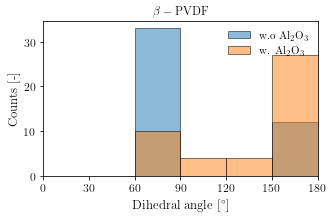

In [43]:
#arr_dihedral00 = arr_dihedral
plt.figure(figsize=[4.8,3.2])
plt.hist(np.abs(arr_dihedral00),bins=np.linspace(0,180,7),edgecolor='k',alpha=0.5,label='w.o $\mathrm{Al_2O_3}$')
plt.hist(np.abs(arr_dihedral),bins=np.linspace(0,180,7),edgecolor='k',alpha=0.5,label='w. $\mathrm{Al_2O_3}$')
plt.xlim([0,180])
plt.xticks(np.linspace(0,180,7))
plt.ylabel("Counts [-]",fontsize=13)
plt.xlabel("Dihedral angle [$\mathrm{^\circ}$]",fontsize=13)
plt.legend(frameon=False)
plt.title(r'$\mathrm{\beta-PVDF}$',fontsize=12)
plt.tight_layout()
#plt.annotate('mid. chain', xy=(130, 1), xytext=(100, 5),arrowprops=dict(arrowstyle="->"))
plt.savefig(base + 'stab.pdf')
plt.savefig(base + 'stab.svg')

In [31]:
np.abs(arr_dihedral)>150

array([False, False,  True, False, False, False,  True, False, False,
       False,  True, False, False, False,  True, False, False, False,
        True, False, False,  True, False, False, False,  True, False,
       False, False,  True, False, False,  True, False, False,  True,
       False, False,  True, False, False,  True, False, False, False])

In [ ]:
from toolz.itertoolz import unique
TransList = list(unique(trans_index))
GaucheList = list(unique(gauche_index))
dftrans=df.loc[TransList]
dftrans.to_csv(base+subbase+'trans.xyz',header=None,index=None,sep=" ")
dfgauche=df.loc[GaucheList]
dfgauche.to_csv(base+subbase+'gauche.xyz',header=None,index=None,sep=" ")

# Combine scripts Multiple Snapshots

In [6]:
base = '/media/gywjedi/gywjedi/PVDF/beta/FF_20210715/Termi_adf_times_noAl/'
natoms = 29120
df = pd.read_csv(base+'0000/xm0',skiprows=2,nrows=natoms,header=None,sep='\s+',usecols=[0,1,2,3,4])
df.columns = ['el','x','y','z','label']
df.index+=1
################
backbone_dihedral_list = []
for j0 in range(1,max(df.label.values)+1):
    tmp00=df.query('el=="C" and label==%(var_0)f'%dict(var_0=j0))
    tmp_sortbyz=tmp00.sort_values(by='z', ascending=True)
    C4_index = [[tmp_sortbyz.index.tolist()[i0],tmp_sortbyz.index.tolist()[i0+1],tmp_sortbyz.index.tolist()[i0+2],tmp_sortbyz.index.tolist()[i0+3]] for i0 in range(len(tmp_sortbyz)-3)]
    backbone_dihedral_list.extend(C4_index)

In [5]:
from toolz.itertoolz import unique
n_frames = 200;
for frames in range(1,n_frames+1):
    DF = pd.read_csv(base+'fort.51',skiprows=2+(2+natoms)*frames,nrows=natoms,
                     header=None,sep='\s+',usecols=[0,1,2,3,4])
    DF.columns = ['el','x','y','z','label']
    DF.index+=1
    trans_index = []
    gauche_index = []
    arr_dihedral = []
    for i1 in backbone_dihedral_list:
        ci1 = DF.loc[i1][['x','y','z']]
        vec_b1 = np.array(ci1.iloc[1])-np.array(ci1.iloc[0])
        vec_b2 = np.array(ci1.iloc[2])-np.array(ci1.iloc[1])
        vec_b3 = np.array(ci1.iloc[3])-np.array(ci1.iloc[2])
        n1=np.cross(vec_b1,vec_b2)/np.linalg.norm(np.cross(vec_b1,vec_b2))
        n2=np.cross(vec_b2,vec_b3)/np.linalg.norm(np.cross(vec_b2,vec_b3))
        x=np.dot(n1,n2)
        b2 = vec_b2/np.linalg.norm(vec_b2)
        m1 = np.cross(n1,b2)
        y=np.dot(m1,n2)
        dihedral = np.degrees(np.arctan2(y,x))
        arr_dihedral.append(dihedral)
        if abs(dihedral)>150:
            trans_index=trans_index+i1
        elif abs(dihedral)> 30 and abs(dihedral)<90:
            gauche_index=gauche_index+i1
            
    TransList = list(unique(trans_index))
    GaucheList = list(unique(gauche_index))
    trans_list = [t.tolist() for t in df.loc[TransList].values]
    with open(base+str(n_frames)+"trans.xyz", "a") as trans:
        trans.write(str(len(TransList))+'\n')
        trans.write('\n')
    dftrans=DF.loc[TransList]
    dftrans.to_csv(base+str(n_frames)+'trans.xyz',header=None,index=None,sep=" ",mode='a')
    with open(base+str(n_frames)+"gauche.xyz", "a") as gauche:
        gauche.write(str(len(GaucheList))+'\n')
        gauche.write('\n')
    dfgauche=DF.loc[GaucheList]
    dfgauche.to_csv(base+str(n_frames)+'gauche.xyz',header=None,index=None,sep=" ",mode='a')

In [ ]:
from scipy.optimize import curve_fit

def func(x,a,b):
    return a*np.log(x)+ b

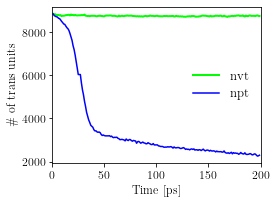

In [22]:
n_frames=200
base = r'/home/gywjedi/ExternalHDD/PVDF/beta/FF_20210715/Termi_adf_times_noAl'
num_trans = np.loadtxt(base+'/200trans.dat')
plt.figure(figsize=[4,3])
plt.plot(range(1,n_frames),num_trans,lw=2,label='nvt',color='lime')
num_trans_npt = np.loadtxt(base+'/npt/200trans.dat')
plt.plot(range(1,n_frames),num_trans_npt,label='npt',color='blue')
plt.xlim([0,200])
plt.xlabel('Time [ps]')
plt.ylabel('\# of trans units')
#popt, pcov = curve_fit(func, np.arange(1,n_frames), num_gauche)
#plt.plot(np.arange(1,n_frames), func(np.arange(1,n_frames), *popt), label="log fit",lw=2,c='r')
plt.legend(loc='center right',frameon=False,fontsize=13)
plt.tight_layout()
plt.savefig(base+'/200ps_evo.svg')

In [ ]:
base = r'/home/gywjedi/ExternalHDD/PVDF/singlechain/al2o3_atermi_adjacent_HO/lmps_10K_01'
_ = pd.read_csv(base+'/out',skiprows=1307,nrows=800,sep="\s+")
plt.plot(_.Step,_.PotEng,lw=2)
plt.show()

In [ ]:
np.mean(_.PotEng)

# Torsion Restraint

In [ ]:
base = r'/home/gywjedi/ExternalHDD/PVDF/singlechain/al2o3_btermi_adjacent_HO/';natoms= 292;
df = pd.read_csv(base+'test/xmolout',skiprows=2,nrows=natoms,header=None,sep='\s+',usecols=[0,1,2,3,4])
df.columns = ['el','x','y','z','label']
df.index+=1
################
backbone_dihedral_list = []
for j0 in range(1,int(max(df.label.values)+1)):
    tmp00=df.query('el=="C" and label==%(var_0)f'%dict(var_0=j0))
    tmp_sortbyz=tmp00.sort_values(by='z', ascending=True)
    C4_index = [[tmp_sortbyz.index.tolist()[i0],tmp_sortbyz.index.tolist()[i0+1],tmp_sortbyz.index.tolist()[i0+2],tmp_sortbyz.index.tolist()[i0+3]] for i0 in range(len(tmp_sortbyz)-3)]
    backbone_dihedral_list.extend(C4_index)
import csv
file = open(base+'test/TorsionRestraint.dat',"w")
writer=csv.writer(file,delimiter=" ")
for i1 in backbone_dihedral_list:
    ci1 = df.loc[i1][['x','y','z']]
    vec_b1 = np.array(ci1.iloc[1])-np.array(ci1.iloc[0])
    vec_b2 = np.array(ci1.iloc[2])-np.array(ci1.iloc[1])
    vec_b3 = np.array(ci1.iloc[3])-np.array(ci1.iloc[2])
    n1=np.cross(vec_b1,vec_b2)/np.linalg.norm(np.cross(vec_b1,vec_b2))
    n2=np.cross(vec_b2,vec_b3)/np.linalg.norm(np.cross(vec_b2,vec_b3))
    x=np.dot(n1,n2)
    b2 = vec_b2/np.linalg.norm(vec_b2)
    m1 = np.cross(n1,b2)
    y=np.dot(m1,n2)
    dihedral = np.degrees(np.arctan2(y,x))
    _ = ['TORSION','RESTRAINT']+i1+[dihedral,250.00,1.0000,0.0000]
    writer.writerow(_)
file.close()

# Random pick H atoms

In [4]:
import random
base = r"/media/gywjedi/gywjedi/PVDF/beta/strain/0TriF/emin"
df = pd.read_csv(base+"/xmolout",skiprows=2,header=None,usecols=[0,1,2,3,4],sep="\s+")
df.index+=1
df.columns=['el','x','y','z','tag']
df_C=df.query("el=='C'")
C_list = df_C.index.tolist()

fort7path = base + '/fort.7'
FORT7 = open(fort7path,'r')
fort7=FORT7.readlines()
FORT7.close()
#Ch_dict={"Ch":[],"H":[]};
num_tag = 32;

for _ in range(1,num_tag+1):
    Ch_dict={"Ch":[],"H":[]};
    for C_index in C_list:
        if df.loc[C_index,'tag'] == _:
            temp = [int(i3) for i3 in fort7[C_index].split()[2:6]]
            temp2 = np.trim_zeros(temp)
            temp3 = []
        for j in temp2:
            if df.loc[j,'el']=="H":
                temp3.append(j)
        if len(temp3)==2:
            Ch_dict["Ch"].append(C_index)
            Ch_dict["H"].append(temp3)
    
    randomlist = random.sample(range(len(Ch_dict['Ch'])), int(len(Ch_dict['Ch'])/24*18))
    for i in randomlist:
        p=random.randint(0,1) 
        H_index2change = Ch_dict["H"][i][p];
        df.loc[H_index2change,'el']='F'

In [3]:
import random
randomlist = random.sample(range(len(Ch_dict['Ch'])), int(len(Ch_dict['Ch'])/2*2))   # choose the percentage of Trifluoro
for i in randomlist:
    p=random.randint(0,1) 
    H_index2change = Ch_dict["H"][i][p];
    df.loc[H_index2change,'el']='F'

In [5]:
df.to_csv(base+"/_75Trifluo.xyz",header=None,sep=" ",index=None)